In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import math
from sklearn.model_selection import train_test_split

# --- Numeric Masking Dataset ---
class NumericMaskingDataset(Dataset):
    def __init__(self, data, mask_prob=0.6):  # Higher mask_prob for robust learning
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        original = self.data[idx]
        mask = (torch.rand(original.shape) < self.mask_prob).float()
        masked_input = original * (1 - mask)
        return masked_input, original, mask

# Sinusoidal Positional Encoding
def get_sinusoidal_encoding(seq_len, embed_dim):
    pe = torch.zeros(seq_len, embed_dim)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Transformer Encoder Model
class NumericEncoder(nn.Module):
    def __init__(self, seq_len, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.embedding = nn.Linear(1, embed_dim)

        pos_enc = get_sinusoidal_encoding(seq_len, embed_dim)
        self.register_buffer("pos_enc", pos_enc.unsqueeze(0))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x_embed = self.embedding(x) + self.pos_enc
        encoder_output = self.transformer_encoder(x_embed)
        output = self.output_projection(encoder_output).squeeze(-1)
        return output

# Example training loop
def train_encoder(model, train_loader, val_loader, epochs=5, lr=1e-3, device='cuda'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        for masked_input, original, mask in train_loader:
            masked_input, original, mask = masked_input.to(device), original.to(device), mask.to(device)
            optimizer.zero_grad()

            predictions = model(masked_input)

            loss = criterion(predictions * mask, original * mask)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        # Validation Phase explicitly
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for masked_input, original, mask in val_loader:
                masked_input, original, mask = masked_input.to(device), original.to(device), mask.to(device)

                predictions = model(masked_input)
                loss = criterion(predictions * mask, original * mask)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


# Monkey Patching to get Attention Weights
def patch_attention(m):
    forward_orig = m.forward

    def wrap(*args, **kwargs):
        kwargs['need_weights'] = True
        kwargs['average_attn_weights'] = False
        return forward_orig(*args, **kwargs)

    m.forward = wrap

# Class to capture attention weights
class AttentionCapture:
    def __init__(self):
        self.weights = []

    def clear(self):
        self.weights = []

from sklearn.model_selection import train_test_split

# Generate your numeric data explicitly (replace with your real data!)
num_samples = 100
input_dim = 43
data = torch.rand((num_samples, input_dim))

# Explicitly split data into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Clearly define train and validation datasets explicitly
train_dataset = NumericMaskingDataset(train_data, mask_prob=0.3)
val_dataset = NumericMaskingDataset(val_data, mask_prob=0.3)

# Clearly define DataLoaders explicitly
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Instantiate model explicitly
model = NumericEncoder(input_dim, embed_dim=256, num_heads=4, num_layers=6, dropout=0.1)

# Explicitly train with validation clearly included
train_encoder(model, train_loader, val_loader, epochs=10, lr=1e-3)

Epoch [1/10], Train Loss: 6.754011, Val Loss: 0.047842
Epoch [2/10], Train Loss: 1.795781, Val Loss: 0.354302
Epoch [3/10], Train Loss: 0.229090, Val Loss: 0.352629
Epoch [4/10], Train Loss: 0.263829, Val Loss: 0.041618
Epoch [5/10], Train Loss: 0.047246, Val Loss: 0.110473
Epoch [6/10], Train Loss: 0.131024, Val Loss: 0.128202
Epoch [7/10], Train Loss: 0.077350, Val Loss: 0.022432
Epoch [8/10], Train Loss: 0.032292, Val Loss: 0.063606
Epoch [9/10], Train Loss: 0.075940, Val Loss: 0.057767
Epoch [10/10], Train Loss: 0.049269, Val Loss: 0.026003


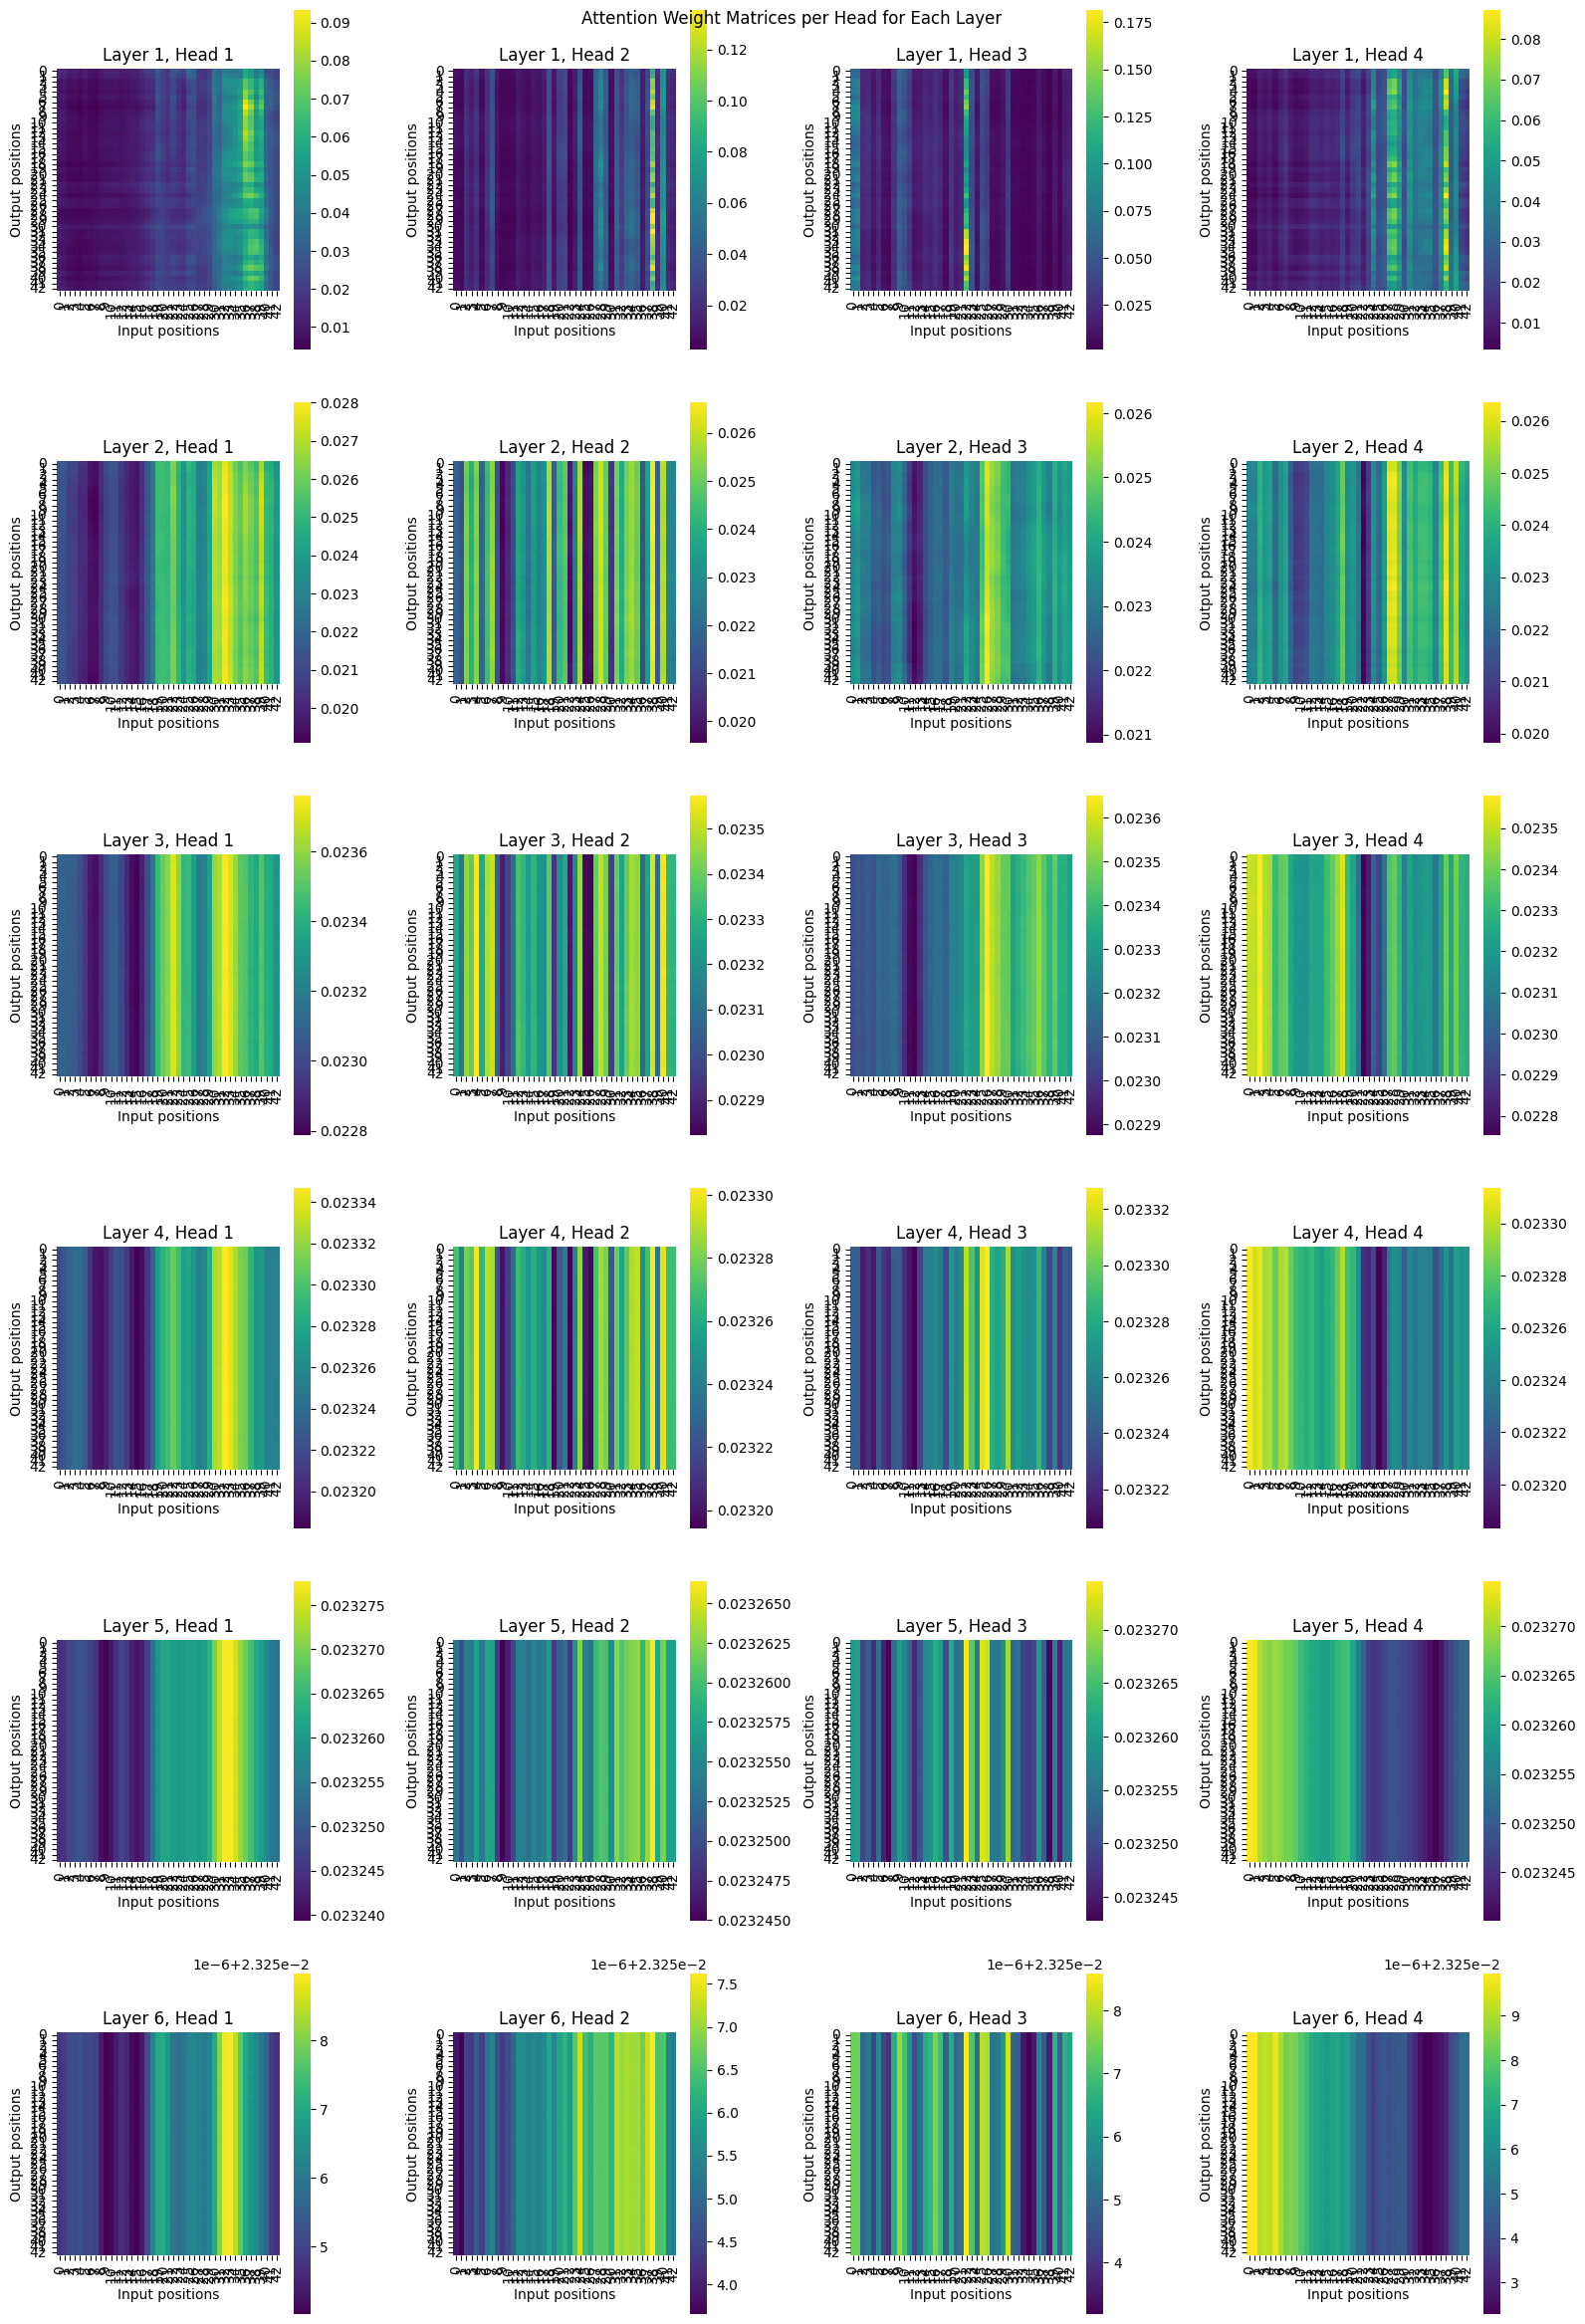

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clear old hooks
for module in model.modules():
    if isinstance(module, nn.MultiheadAttention):
        module._forward_hooks.clear()

# Apply monkey patching and hooks
attn_capture = AttentionCapture()
for module in model.modules():
    if isinstance(module, nn.MultiheadAttention):
        patch_attention(module)
        module.register_forward_hook(lambda mod, inp, out: attn_capture.weights.append(out[1]))

# Example forward pass
attn_capture.clear()
model.cpu()  # moves model to CPU
sample_input = torch.rand((1, input_dim))
output = model(sample_input)  # now both model & input are on CPU

# Determine the number of layers and heads
num_layers = len(attn_capture.weights)
num_heads = attn_capture.weights[0].shape[1]
batch_idx = 0  # first example in the batch

# Create a grid with rows = layers and columns = heads
fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 4, num_layers * 4))

# If only one layer exists, axes might be 1D. We ensure it's 2D.
if num_layers == 1:
    axes = np.expand_dims(axes, axis=0)

for layer in range(num_layers):
    layer_attn = attn_capture.weights[layer]
    for head in range(num_heads):
        ax = axes[layer, head]
        sns.heatmap(
            layer_attn[batch_idx, head].detach().cpu().numpy(),
            cmap='viridis',
            cbar=True,
            ax=ax,
            square=True,
            xticklabels=True,
            yticklabels=True
        )
        ax.set_title(f'Layer {layer+1}, Head {head+1}')
        ax.set_xlabel('Input positions')
        ax.set_ylabel('Output positions')

plt.suptitle('Attention Weight Matrices per Head for Each Layer')
plt.tight_layout()
plt.show()


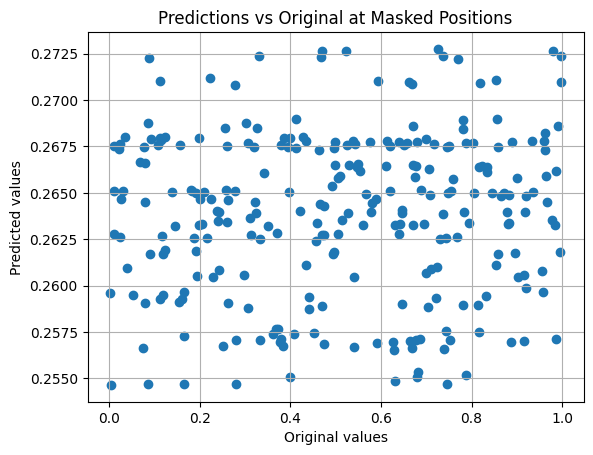

In [ ]:
import matplotlib.pyplot as plt

masked_input, original, mask = next(iter(val_loader))
predictions = model(masked_input)

# Plot original vs predictions on masked positions
import matplotlib.pyplot as plt

masked_positions = mask.bool()

plt.scatter(original[mask.bool()].cpu().numpy(), predictions[mask.bool()].detach().cpu().numpy())
plt.xlabel('Original values')
plt.ylabel('Predicted values')
plt.title('Predictions vs Original at Masked Positions')
plt.grid(True)
plt.show()


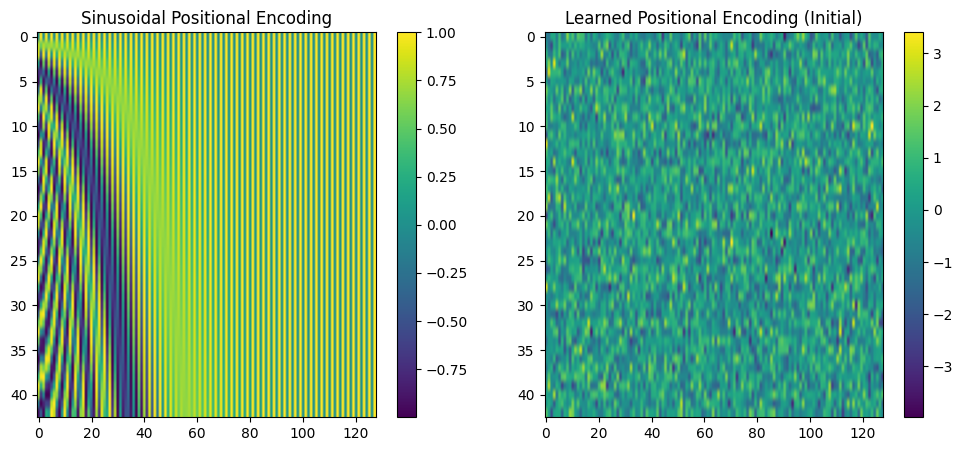

In [ ]:
import torch
import math
import matplotlib.pyplot as plt

def get_sinusoidal_encoding(seq_len, embed_dim):
    pe = torch.zeros(seq_len, embed_dim)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Define sequence length and embedding dimension
seq_len = 43
embed_dim = 128

# Generate sinusoidal encodings
sinusoidal_pe = get_sinusoidal_encoding(seq_len, embed_dim)

# Simulate a learned positional embedding (initial random state)
learned_pe = torch.randn(1, seq_len, embed_dim).squeeze(0)

# Visualize both
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Sinusoidal Positional Encoding")
plt.imshow(sinusoidal_pe.numpy(), aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Learned Positional Encoding (Initial)")
plt.imshow(learned_pe.numpy(), aspect='auto')
plt.colorbar()

plt.show()
